In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
WL_predictor = pd.read_csv('data\ML_processed.csv')
WL_predictor.head()

,moves,my_rating,opponent_rating,outcome,my_accuracy,opponent_accuracy,rating_difference,time_format_Blitz,time_format_Bullet,time_format_Rapid,colour_Black,colour_White
0,62,557,356,W,42.3,57.6,201,0,0,1,0,1
1,40,643,438,W,64.7,77.7,205,0,0,1,1,0
2,25,531,577,L,58.3,76.4,-46,0,0,1,1,0
3,64,625,615,W,81.4,77.5,10,0,0,1,0,1
4,12,564,639,L,31.6,55.5,-75,0,0,1,0,1


In [3]:
WL_predictor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9183 entries, 0 to 9182
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   moves               9183 non-null   int64  
 1   my_rating           9183 non-null   int64  
 2   opponent_rating     9183 non-null   int64  
 3   outcome             9183 non-null   object 
 4   my_accuracy         9183 non-null   float64
 5   opponent_accuracy   9183 non-null   float64
 6   rating_difference   9183 non-null   int64  
 7   time_format_Blitz   9183 non-null   int64  
 8   time_format_Bullet  9183 non-null   int64  
 9   time_format_Rapid   9183 non-null   int64  
 10  colour_Black        9183 non-null   int64  
 11  colour_White        9183 non-null   int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 861.0+ KB


In [5]:
X = WL_predictor.drop(columns = ['outcome'])
y = WL_predictor.loc[:,['outcome']]

from sklearn.model_selection import train_test_split

val_size = 0.3
test_size = 0.2

# create train, validation, and test sets
X_train, X_vt, y_train, y_vt = train_test_split(X, y, test_size = val_size, random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_vt, y_vt, test_size = test_size, random_state = 1)

# FLatten out outcome variable array for sklearn API
y_train = y_train.to_numpy().ravel()
y_val = y_val.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

print('Train set size:', X_train.shape[0])
print('Validation set size:', X_val.shape[0])
print('Test set size:', X_test.shape[0])

Train set size: 6428
Validation set size: 2204
Test set size: 551


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [8]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tabulate import tabulate

The accuracy of our logistic regression model is: 90.47%.
The recall of our logistic regression model is: 91.11%.
Feature               Coefficient
------------------  -------------
moves                  0.0237373
my_rating              0.00536287
opponent_rating       -0.00565935
my_accuracy            0.27497
opponent_accuracy     -0.268613
rating_difference      0.0110222
time_format_Blitz     -0.268237
time_format_Bullet    -0.0292549
time_format_Rapid     -0.224508
colour_Black          -0.100532
colour_White          -0.421467


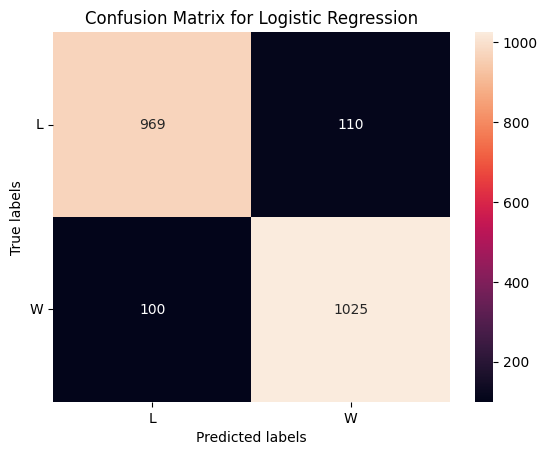

In [23]:
lr = LogisticRegression(max_iter = 1000, random_state = 0)
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_val)

lr_accuracy = accuracy_score(y_val, lr_y_pred)
lr_recall = recall_score(y_val, lr_y_pred, pos_label="W")

print(f'The accuracy of our logistic regression model is: {np.round(lr_accuracy, 4)*100}%.')
print(f'The recall of our logistic regression model is: {np.round(lr_recall, 4)*100}%.')

lr_cm = confusion_matrix(y_val, lr_y_pred)
lr_labels = lr.classes_

ax = plt.subplot()
sns.heatmap(lr_cm, annot=True, ax = ax,fmt="d")
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Logistic Regression')
ax.yaxis.set_tick_params(rotation=360)

ax.xaxis.set_ticklabels(lr_labels) 
ax.yaxis.set_ticklabels(lr_labels)

feature_importance = list(zip(lr.feature_names_in_, lr.coef_[0]))
print(tabulate(feature_importance,headers=['Feature','Coefficient']))

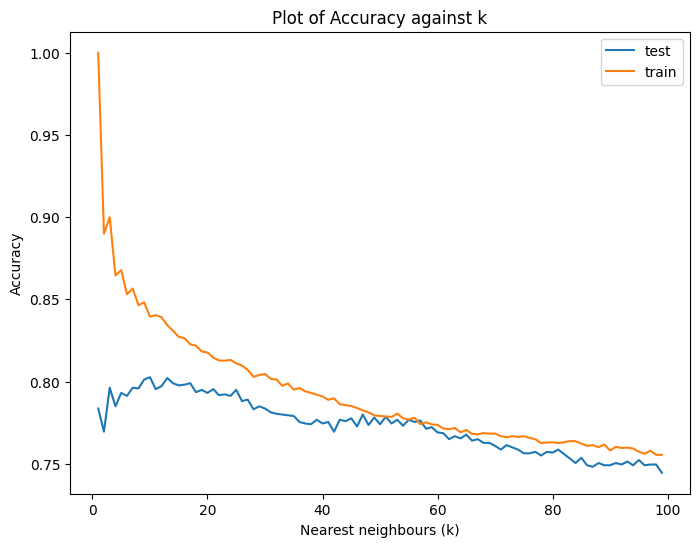

     k  accuracy
9   10  0.802632
12  13  0.802178
8    9  0.801270
13  14  0.799002
16  17  0.799002
Our best K Nearest Neighbours model is obtained with k = 10 with an accuracy of 80.3%.


In [25]:
ks, KNN_scores,KNN_train_scores = [],[],[]
for k in range(1,100):
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,y_train)
    KNN_preds = KNN.predict(X_val)
    KNN_train_preds = KNN.predict(X_train)
    KNN_accuracy = accuracy_score(y_val, KNN_preds)
    KNN_train_accuracy = accuracy_score(y_train, KNN_train_preds)
    ks.append(k)
    KNN_scores.append(KNN_accuracy)
    KNN_train_scores.append(KNN_train_accuracy)
    
fig = plt.figure(figsize=(8,6))
ks = np.array(ks)
KNN_scores = np.array(KNN_scores)
KNN_train_scores = np.array(KNN_train_scores)
plt.plot(ks,KNN_scores,label='test')
plt.plot(ks,KNN_train_scores,label='train')
plt.legend(loc='upper right')
plt.xlabel('Nearest neighbours (k)')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy against k')
plt.show()


# make DataFrame of k's with corresponding accuracies for easy access
KNN_scores_df = pd.DataFrame({'k':ks,'accuracy':KNN_scores})

# get top 5 k's with best accuracies
print(KNN_scores_df.sort_values(by='accuracy',ascending=False)[:5])

KNN_best_k = KNN_scores_df.iloc[KNN_scores_df.accuracy.argmax(),0]
KNN_best_k_accuracy = KNN_scores_df.accuracy.max()

print(f'Our best K Nearest Neighbours model is obtained with k = {KNN_best_k} \
with an accuracy of {np.round(KNN_best_k_accuracy*100,1)}%.')

The accuracy of our KNN model is: 80.4%.
The recall of our KNN model is: 78.69%.


[Text(0, 0.5, 'L'), Text(0, 1.5, 'W')]

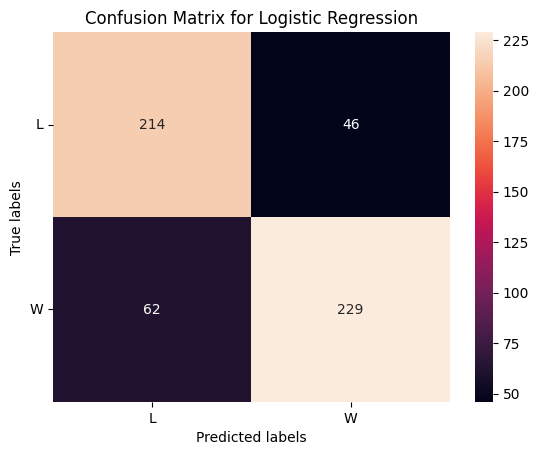

In [31]:
KNN = KNeighborsClassifier(n_neighbors = KNN_best_k)
KNN.fit(X_train, y_train)
KNN_y_pred = KNN.predict(X_test)

KNN_accuracy = accuracy_score(y_test, KNN_y_pred)
KNN_recall = recall_score(y_test, KNN_y_pred, pos_label="W")

print(f'The accuracy of our KNN model is: {np.round(KNN_accuracy, 4)*100}%.')
print(f'The recall of our KNN model is: {np.round(KNN_recall, 4)*100}%.')

KNN_cm = confusion_matrix(y_test, KNN_y_pred)
KNN_labels = KNN.classes_

ax = plt.subplot()
sns.heatmap(KNN_cm, annot=True, ax = ax, fmt="d")
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Logistic Regression')
ax.yaxis.set_tick_params(rotation = 360)

ax.xaxis.set_ticklabels(KNN_labels) 
ax.yaxis.set_ticklabels(KNN_labels)

In [36]:
# convert outcome variable to binary form for xgboost
y_train = (y_train == 'W').astype(int)

# make D matrix to ingest data into xgboost
WL_dmatrix = xgb.DMatrix(data = X_train, label = y_train)

# create parameter dictionary
gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.5, 0.9],
                  'n_estimators': [10, 100, 250, 500],
                  'subsample': [0.3, 0.5, 0.9]}

# instantiate xgboost classifier, grid search and fit to data
gbm = xgb.XGBClassifier(objective = 'binary:logistic', seed = 0)
grid_acc = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'accuracy', cv = 4, verbose = 1)
grid_acc.fit(X_train, y_train)

print("Best parameters found: ", grid_acc.best_params_)
print(f"Highest accuracy found:  {np.round(grid_acc.best_score_*100, 2)}%")


Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best parameters found:  {'learning_rate': 0.01, 'n_estimators': 500, 'subsample': 0.5}
Highest accuracy found:  0.9080584940883634
